# Nhập thư viện

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, Dense,Activation, Flatten, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.layers import MaxPooling2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow import keras

Tải dữ liệu

In [ ]:
def loading_the_data(data_dir):
  filepaths=[]
  labels=[]

  folds=os.listdir(data_dir)
  for fold in folds:
    foldpath=os.path.join(data_dir, fold)
    filelist=os.listdir(foldpath)
    for file in filelist:
      fpath=os.path.join(foldpath, file)
      filepaths.append(fpath)
      labels.append(fold)

  Fseries = pd.Series(filepaths, name='filepaths')
  Lseries = pd.Series(labels, name='labels')

  df = pd.concat([Fseries, Lseries], axis=1)

  return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/images'
df = loading_the_data(data_dir)
df

flower_categories = os.listdir(data_dir)
print(f" Flower classes : {flower_categories}")

 Flower classes : ['tulip', 'daisy', 'dandelion', 'sunflower', '.ipynb_checkpoints']


# Trực quan hóa dữ liệu

In [ ]:
classes = []
num_files = []
for category in flower_categories:
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        classes.append(category)
        num_files.append(len(os.listdir(category_path)))
print(f"Flower classes: {classes}")
print(f"Number of files in each class: {num_files}")

Flower classes: ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']
Number of files in each class: [1052, 764, 733, 984, 784]


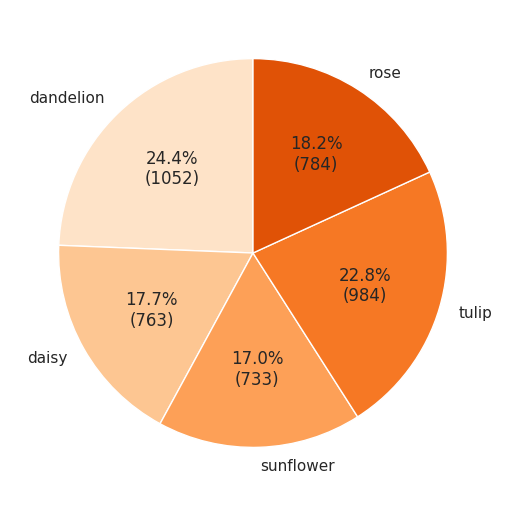

In [ ]:
colors = sns.color_palette("Oranges")
def func(pct, allvals):
    absolute = int(pct/100.*sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)
plt.figure(figsize=(6,6))
plt.pie(num_files, labels=classes, autopct=lambda pct: func(pct, num_files),
        startangle=90, colors=colors);

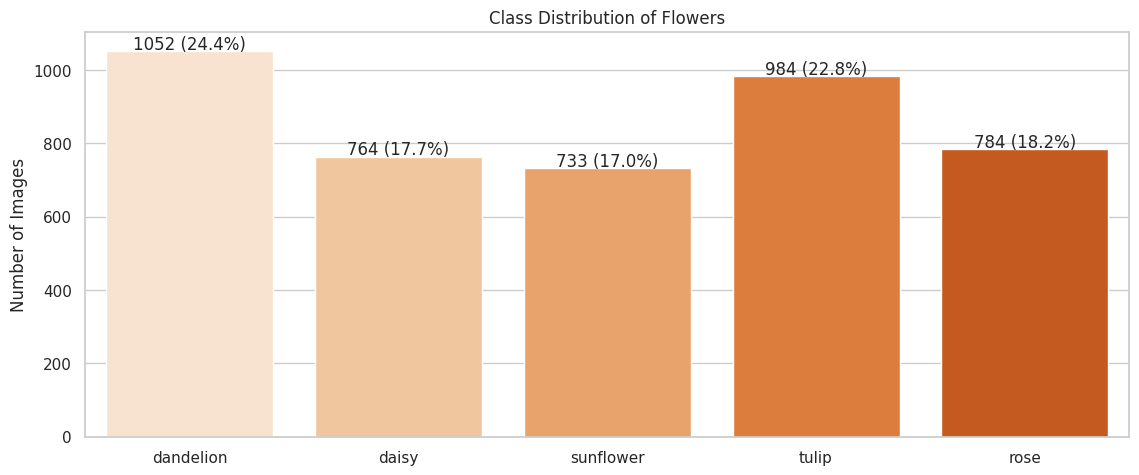

In [ ]:
def plot_class_distribution(classes, num_files):
    total = sum(num_files)
    plt.figure(figsize=(12, 5))
    sns.barplot(x=classes, y=num_files, palette=colors)
    for i in range(len(num_files)):
        count = num_files[i]
        pct = count / total * 100
        plt.text(i, count + 5, f'{count} ({pct:.1f}%)', ha='center')
    plt.title('Class Distribution of Flowers')
    plt.ylabel('Number of Images')
    plt.show()
plot_class_distribution(classes, num_files)

Hiển thị ngẫu nhiên ảnh của mỗi lớp hoa

In [ ]:
import random
import matplotlib.image as mpimg
def display_random_images(category, num_images=5):
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        selected_images = random.sample(images, num_images)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i, image_name in enumerate(selected_images):
            image_path = os.path.join(category_path, image_name)
            img = mpimg.imread(image_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Shape: {img.shape}")
        plt.tight_layout()
        plt.show()

In [ ]:
classes

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

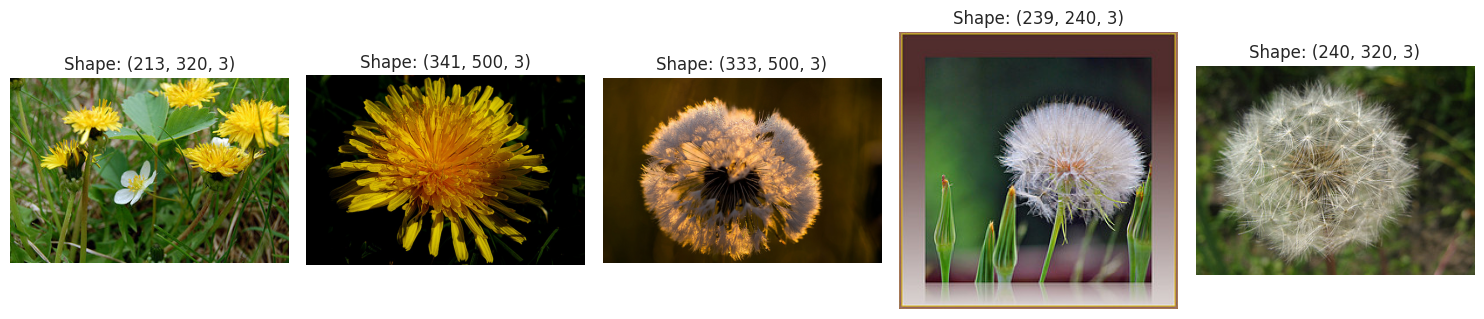

In [ ]:
display_random_images('dandelion')

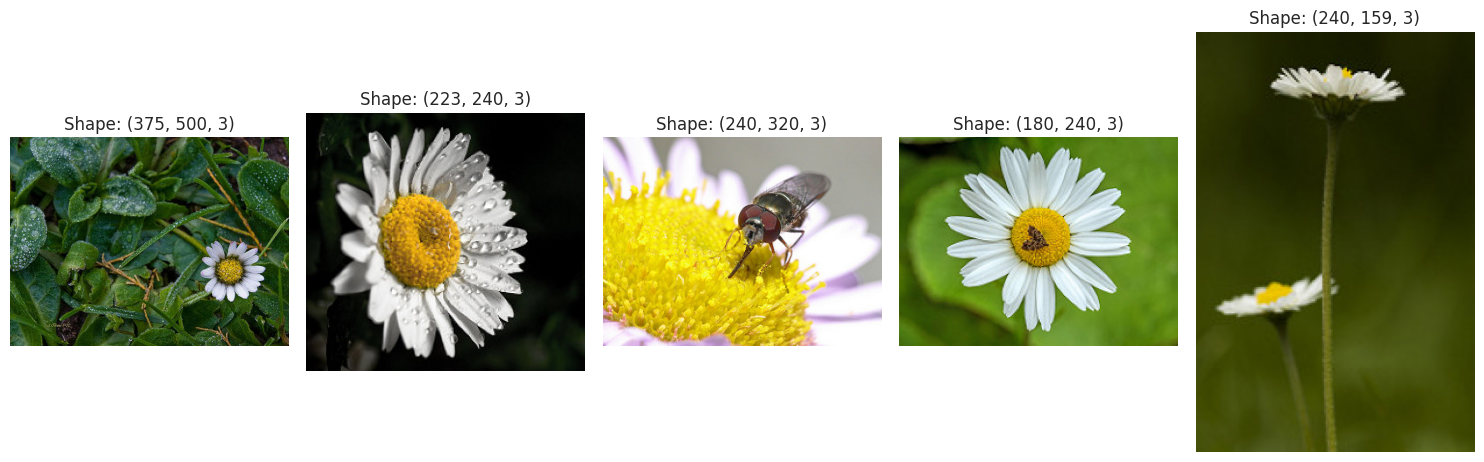

In [ ]:
display_random_images('daisy')

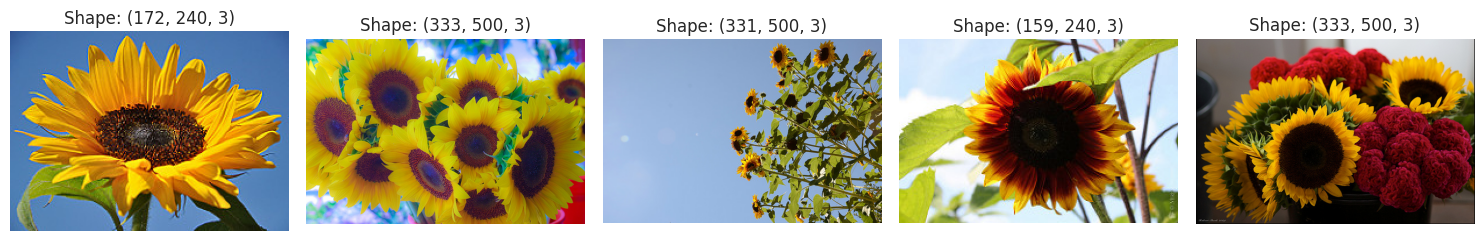

In [ ]:
display_random_images('sunflower')

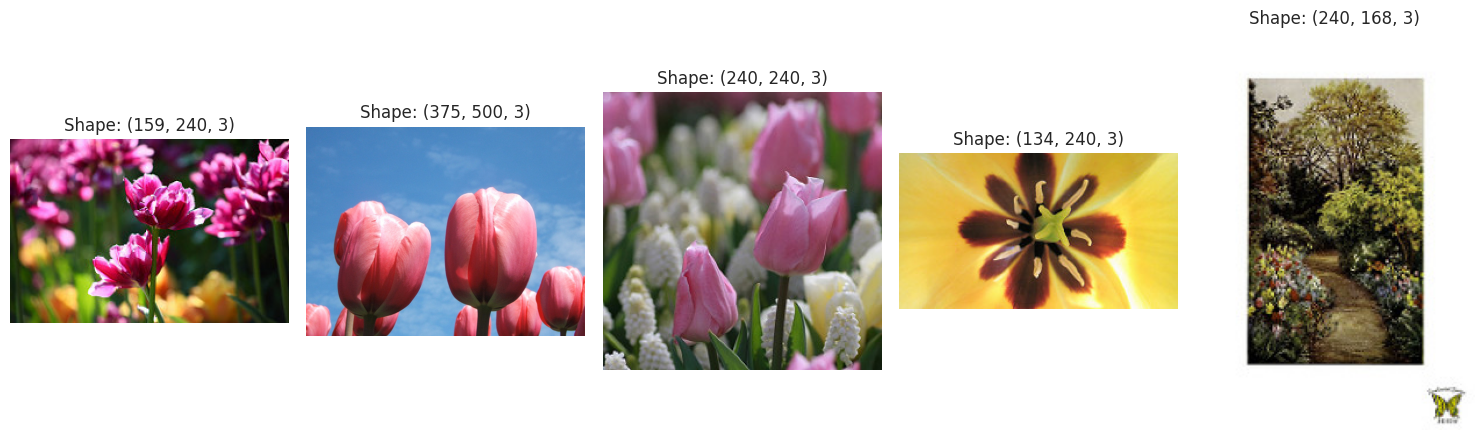

In [ ]:
display_random_images('tulip')

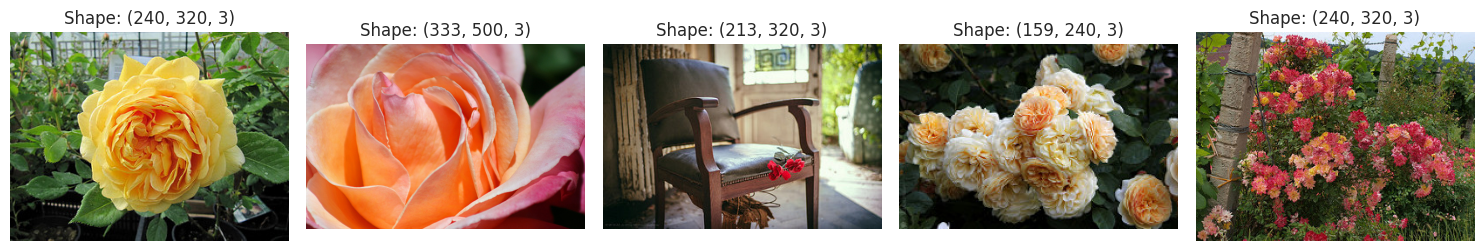

In [ ]:
display_random_images('rose')

Kiểm tra giá trị pixels

In [ ]:
for category in flower_categories:
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        if len(images) > 17:
            image_name = images[17]
            image_path = os.path.join(category_path, image_name)
            img = mpimg.imread(image_path)
            print(f'{category} index 17 max: {img.max()}')
            print(f'{category} index 17 min: {img.min()}')
        else:
            print(f"{category} does not have an image at index 17.")

dandelion index 17 max: 255
dandelion index 17 min: 0
daisy index 17 max: 255
daisy index 17 min: 0
sunflower index 17 max: 255
sunflower index 17 min: 0
tulip index 17 max: 255
tulip index 17 min: 0
rose index 17 max: 255
rose index 17 min: 0


Hình dạng trung bình của ảnh

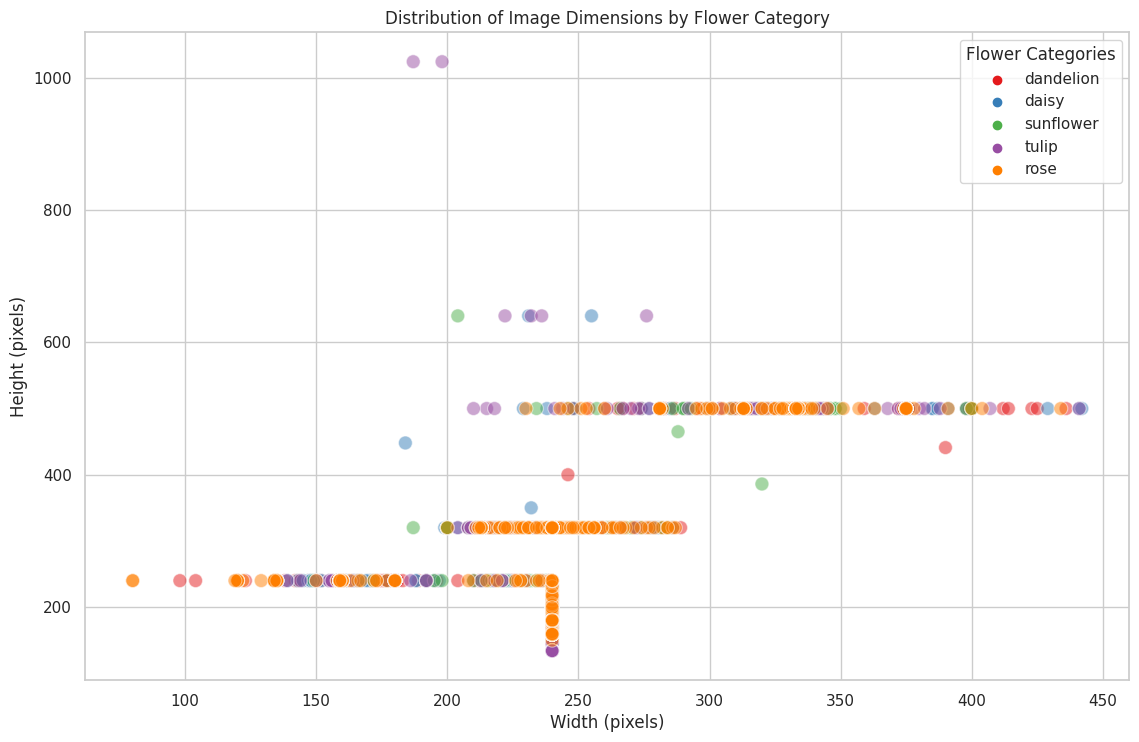

Mean height (x): 253.07
Mean width (y): 338.38


In [ ]:
x, y, categories = [], [], []

for category in flower_categories:
    category_path = os.path.join(data_dir, category)
    files = os.listdir(category_path)
    for image in files:
        try:
            img = mpimg.imread(os.path.join(category_path, image))
            d1, d2, _ = img.shape
            x.append(d1)
            y.append(d2)
            categories.append(category)
        except OSError as e:
            print(f"Error processing {image}: {e}")
            continue
plt.figure(figsize=(12, 8))
sns.scatterplot(x=x, y=y, hue=categories, palette='Set1', alpha=0.5, s=100)
plt.title('Distribution of Image Dimensions by Flower Category')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.legend(title='Flower Categories')
plt.grid(True)
plt.show()

print(f'Mean height (x): {np.mean(x):.2f}')
print(f'Mean width (y): {np.mean(y):.2f}')

# Tiền xử lý dữ liệu

In [ ]:
seed=42
image_shape = (224, 224, 3)
epochs = 50
target_size=(224, 224)
batch_size = 32
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0)

In [ ]:
# Chia dữ liệu
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [ ]:
train_aug_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = train_aug_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode="categorical",
    shuffle=True
)

val_gen = image_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode="categorical",
    shuffle=False)

test_gen = image_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode="categorical",
    shuffle=False)

Found 3453 validated image filenames belonging to 5 classes.
Found 432 validated image filenames belonging to 5 classes.
Found 432 validated image filenames belonging to 5 classes.


In [ ]:
train_size = len(train_gen)
val_size = len(val_gen)
test_size = len(test_gen)

#Tính toán kích thước của tập dữ liệu
total_size = train_size + val_size + test_size
train_ratio = train_size / total_size
val_ratio = val_size / total_size
test_ratio = test_size / total_size

# Chuẩn bị dữ liệu cho biểu đồ
data_sets = ['Training + Validation', 'Testing']
train_val_values = [train_ratio, 0]
val_values = [val_ratio, 0]
test_values = [0, test_ratio]

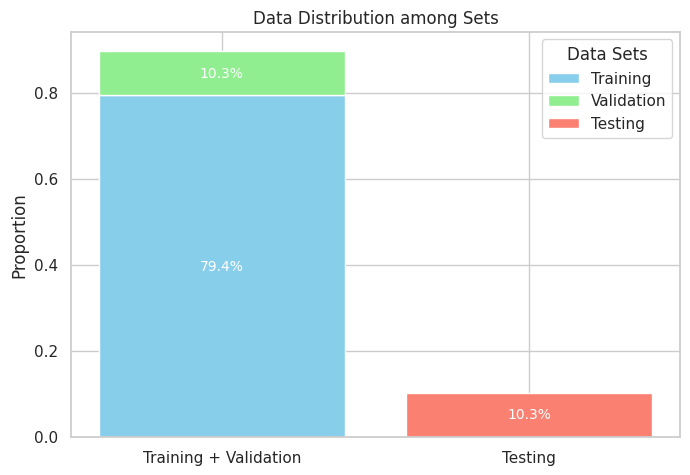

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
colors = ['skyblue', 'lightgreen', 'salmon']
ax.bar(data_sets, train_val_values, color=colors[0], label='Training')
ax.bar(data_sets, val_values, bottom=train_val_values, color=colors[1], label='Validation')
ax.bar(data_sets, test_values, color=colors[2], label='Testing')
ax.set_ylabel('Proportion')
ax.set_title('Data Distribution among Sets')
ax.legend(title='Data Sets', loc='upper right')
ax.text(0, train_ratio/2, f'{train_ratio:.1%}', ha='center', va='center', color='white', fontsize=10)
ax.text(0, train_ratio + val_ratio/2, f'{val_ratio:.1%}', ha='center', va='center', color='white', fontsize=10)
ax.text(1, test_ratio/2, f'{test_ratio:.1%}', ha='center', va='center', color='white', fontsize=10)

plt.show()

In [ ]:
#đánh giá mô hình
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose=1)
    valid_score = model.evaluate(val_gen, verbose=1)
    test_score = model.evaluate(test_gen, verbose=1)

    print('-' * 20)
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    print('-' * 20)

In [ ]:
#Hiển thị hiệu suất của mô hình
def model_performance(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(1, len(tr_acc) + 1)
    plt.figure(figsize=(20, 7))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_acc, 'blue', marker='o',label='Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', marker='o',label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_loss, 'blue',marker='o', label='Training loss')
    plt.plot(epochs, val_loss, 'orange', marker='o',label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
#Ma trận nhầm lẫn
from itertools import product

def plot_confusion_matrix(test_gen, y_pred):
    classes = list(test_gen.class_indices.keys())
    cm = confusion_matrix(test_gen.classes, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Oranges')
    plt.title('Confusion Matrix', fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    thresh = cm.max() / 2
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], ha='center', fontsize=10,
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()